# Connect to Chinook Database

In [14]:
from sqlalchemy import create_engine, inspect
import pandas as pd

### Connect database Chinook.sqlite

In [15]:
engine = create_engine("sqlite:///Chinook.sqlite")
inspector = inspect(engine)
table_names = inspector.get_table_names()
table_names # Check table names

['Album',
 'Artist',
 'Customer',
 'Employee',
 'Genre',
 'Invoice',
 'InvoiceLine',
 'MediaType',
 'Playlist',
 'PlaylistTrack',
 'Track']

### Check out Queen's artist id

In [16]:
queen_df = pd.read_sql_query("SELECT * FROM Artist WHERE Name = 'Queen'", con=engine)
queen_id = int(queen_df["ArtistId"].values[0])
queen_id

51

### Check out Queen's albums

In [17]:
queen_album = pd.read_sql_query(f"SELECT * FROM Album WHERE ArtistId = {queen_id}", con=engine)
queen_album

,AlbumId,Title,ArtistId
0,36,Greatest Hits II,51
1,185,Greatest Hits I,51
2,186,News Of The World,51


In [18]:
album_id = queen_album["AlbumId"].values
album_id = tuple(map(lambda x: int(x), album_id))
album_id

(36, 185, 186)

### Check out Genre Table

In [19]:
genre_df = pd.read_sql_query("SELECT * FROM Genre", con=engine)
genre_df.head()

,GenreId,Name
0,1,Rock
1,2,Jazz
2,3,Metal
3,4,Alternative & Punk
4,5,Rock And Roll


In [20]:
# All Queen's song is Rock
queen_genre = pd.read_sql_query(f"SELECT * FROM Track WHERE AlbumId IN {album_id} AND GenreId != 1", con=engine)
queen_genre

,TrackId,Name,AlbumId,MediaTypeId,GenreId,Composer,Milliseconds,Bytes,UnitPrice


### Check out Queen's tracks

In [21]:
track_df = pd.read_sql_query(f"SELECT * FROM Track WHERE AlbumId IN {album_id}", con=engine)
len(track_df)

45

# Do Web Scraping

In [22]:
import gazpacho as gaz
import requests

In [23]:
url = "https://kworb.net/spotify/artist/1dfeR4HaWDbWqFHLkxsg1d_songs.html"
response = requests.get(url)
response.status_code

200

In [24]:
txt = gaz.Soup(response.text)
table = txt.find("table")
table = table[1].find("td") # find table and td tag

In [25]:
songs = []
for line in table:
    x = line.find("td")
    if x:
        songs.append(x.strip())

In [26]:
song_clean = []
total_clean = []
daily_clean = []

for i in range(0, len(songs), 3):
    idx = songs[i].find(" - ")
    res1 = songs[i][:idx]
    
    clean_res2 = songs[i+1].split(",")
    res2 = int("".join(clean_res2))
    
    clean_res3 = songs[i+2].split(",")
    res3 = int("".join(clean_res3))
    
    song_clean.append(res1)
    total_clean.append(res2)
    daily_clean.append(res3)
    

In [27]:
len(song_clean) # check len of list

500

In [28]:
list_of_tuples = list(zip(song_clean, total_clean, daily_clean))
df = pd.DataFrame(list_of_tuples, columns=["Name", "Streams", "Daily"])
df[df["Name"] == "Bohemian Rhapsody"]

,Name,Streams,Daily
0,Bohemian Rhapsody,2700521899,904097
42,Bohemian Rhapsody,80003277,14016
80,Bohemian Rhapsody,21912861,5584
95,Bohemian Rhapsody,14208764,3865
140,Bohemian Rhapsody,7979168,1804
187,Bohemian Rhapsody,5081887,547
225,Bohemian Rhapsody,4184494,576
283,Bohemian Rhapsody,2967978,206
289,Bohemian Rhapsody,2915969,562
407,Bohemian Rhapsody,1316013,321


In [29]:
df.iloc[200:]

,Name,Streams,Daily
200,Man On The Prowl,4736439,1159
201,We Will Rock You (Fast),4733540,1117
202,My Life Has Been Saved,4732262,1380
203,Rain Must Fall,4635925,1968
204,Tear It Up,4632574,946
...,...,...,...
495,Pain Is So Close To Pleasure,770468,161
496,Flash,768190,96
497,Bring Back That Leroy Brown,767488,148
498,A Kind Of Magic,760677,139


Filter the duplicate name and remain the highest streams column

In [30]:
idx = df.groupby("Name")["Streams"].idxmax()
df_filtered = df.loc[idx]
len(df_filtered)

243

## Data Cleaning

In [31]:
track_full = pd.merge(df_filtered, track_df, on="Name", how="inner")
track_full.head()

,Name,Streams,Daily,TrackId,AlbumId,MediaTypeId,GenreId,Composer,Milliseconds,Bytes,UnitPrice
0,A Kind Of Magic,296827015,163639,419,36,1,1,Roger Taylor,262608,8689618,0.99
1,"All Dead, All Dead",25478170,3794,2274,186,1,1,May,190119,6144878,0.99
2,Another One Bites The Dust,2087240597,791461,2255,185,1,1,"Deacon, John",216946,7172355,0.99
3,Bicycle Race,163722437,43247,2258,185,1,1,"Mercury, Freddie",183823,6012409,0.99
4,Bohemian Rhapsody,2700521899,904097,2254,185,1,1,"Mercury, Freddie",358948,11619868,0.99


In [32]:
composer = list(track_full["Composer"])
clean1 = []
for ele in composer:
    if "/" in ele:
        idx = ele.find("/")
        one = ele[:idx]
        two = ele[idx+1:]
        
        if ", " in one and ", " in two:
            res1 = one.split(", ")
            one = " ".join(res1)
            
            res2 = one.split(", ")
            two = " ".join(res2)
        
        if one != two:  
            clean1.append(one + " & " + two)
        else:
            clean1.append(one)
    else:
        clean1.append(ele)

In [33]:
clean2 = []
for ele in clean1:
    if "&" in ele:
         clean2.append(ele)
    else:   
        if "Taylor" in ele or "Roger" in ele:
            clean2.append("Roger Taylor")
        elif "May" in ele or "Brian" in ele:
            clean2.append("Brian May")
        elif "John" in ele or "Deacon" in ele:
            clean2.append("John Deacon")
        else:
            clean2.append("Freddie Mercury")
            person = "Freddie Mercury"

In [34]:
clean_df = pd.DataFrame({"Clean_composer":clean2})

In [35]:
track_full["Clean_composer"] = clean_df
track_full = track_full.drop("Composer", axis=1)
track_full = track_full.rename(columns={"Clean_composer":"Composer"})
track_full.head()

,Name,Streams,Daily,TrackId,AlbumId,MediaTypeId,GenreId,Milliseconds,Bytes,UnitPrice,Composer
0,A Kind Of Magic,296827015,163639,419,36,1,1,262608,8689618,0.99,Roger Taylor
1,"All Dead, All Dead",25478170,3794,2274,186,1,1,190119,6144878,0.99,Brian May
2,Another One Bites The Dust,2087240597,791461,2255,185,1,1,216946,7172355,0.99,John Deacon
3,Bicycle Race,163722437,43247,2258,185,1,1,183823,6012409,0.99,Freddie Mercury
4,Bohemian Rhapsody,2700521899,904097,2254,185,1,1,358948,11619868,0.99,Freddie Mercury


# Data analysis and Visualization

In [36]:
import matplotlib.pyplot as plt
import numpy as np

## Total Streams by Album

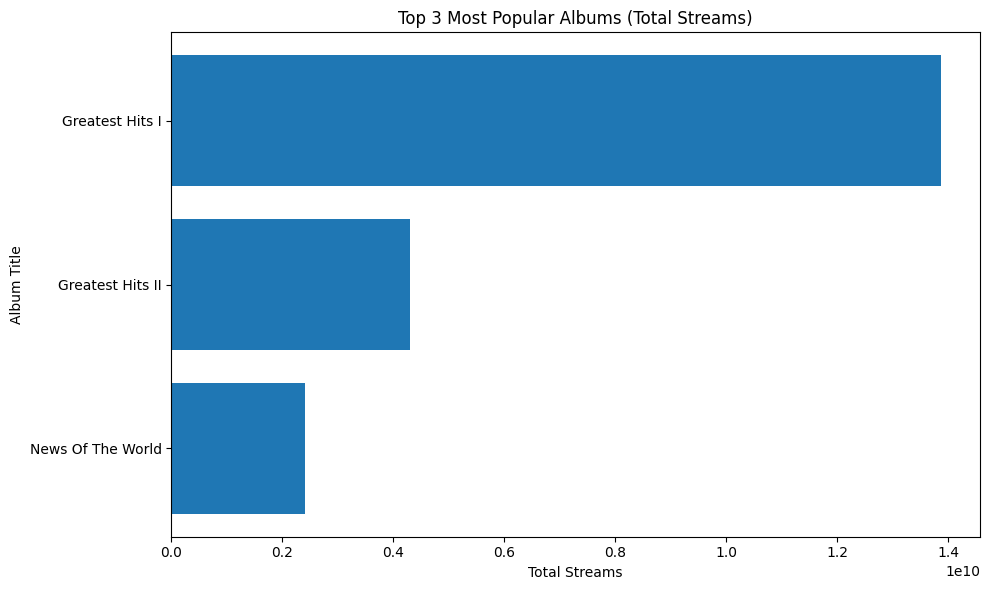

In [37]:
album_hit = track_full.groupby("AlbumId")["Streams"].sum()
album_hit_df = pd.merge(queen_album, album_hit, on="AlbumId", how="inner").sort_values("Streams")

plt.figure(figsize=(10, 6))
plt.barh(album_hit_df["Title"], album_hit_df["Streams"])
plt.subplots_adjust(left=0.3)

plt.ylabel("Album Title")
plt.xlabel("Total Streams")
plt.title("Top 3 Most Popular Albums (Total Streams)")

plt.tight_layout()
plt.show()

## Top 10 Most Popular Songs

In [38]:
song_hit = track_full.sort_values(by="Streams", ascending=False)
song_hit = song_hit.iloc[:10][["Name", "Streams", "Daily"]]
song_hit

,Name,Streams,Daily
4,Bohemian Rhapsody,2700521899,904097
7,Don't Stop Me Now,2229570971,1004500
2,Another One Bites The Dust,2087240597,791461
35,Under Pressure,1802591503,828859
38,We Will Rock You,1457441544,496254
39,We Will Rock You,1457441544,496254
6,Crazy Little Thing Called Love,1049430077,486873
30,Somebody To Love,965113019,382939
22,Killer Queen,940127591,361595
36,We Are The Champions,780992655,265049


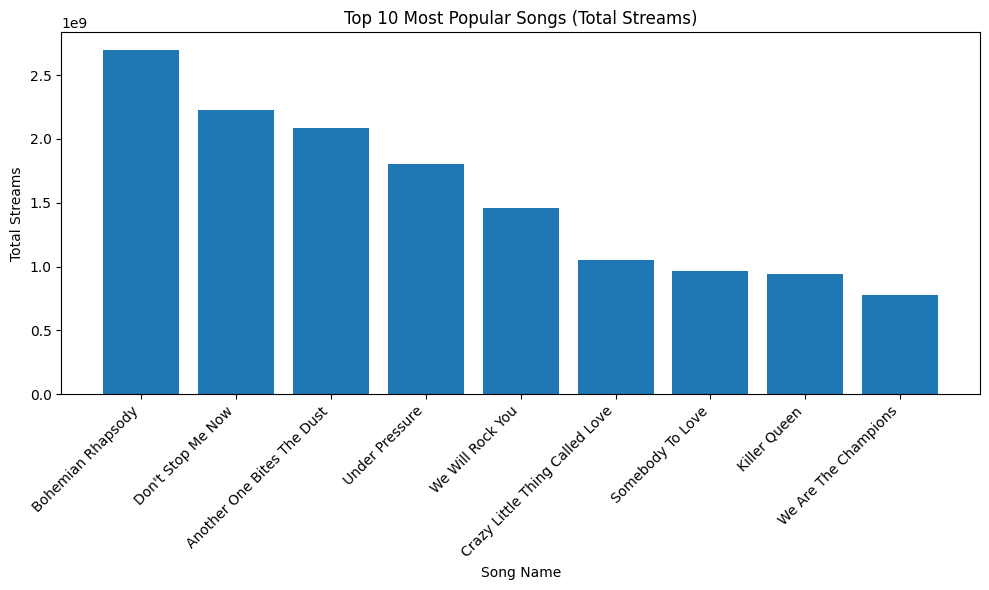

In [39]:
plt.figure(figsize=(10, 6))
plt.bar(song_hit["Name"], song_hit["Streams"])

plt.xlabel("Song Name")
plt.ylabel("Total Streams")
plt.title("Top 10 Most Popular Songs (Total Streams)")
plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()

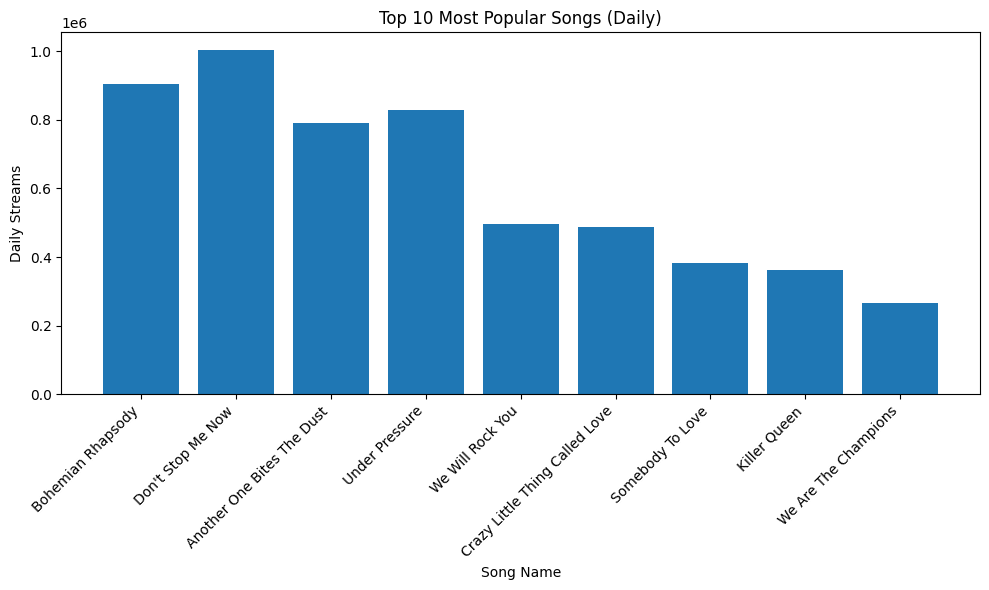

In [40]:
# Restart kernel for lastest update
plt.figure(figsize=(10, 6))
plt.bar(song_hit["Name"], song_hit["Daily"])

plt.xlabel("Song Name")
plt.ylabel("Daily Streams")
plt.title("Top 10 Most Popular Songs (Daily)")
plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()

## Length of Top 10 Most Popular Songs

In [41]:
song_hit = track_full.sort_values(by="Streams", ascending=False)
hit_calculation = song_hit[["Name", "Milliseconds"]].iloc[:10]
hit_calculation["Minute"] = round(hit_calculation["Milliseconds"] / (1000 * 60.0), 2)
hit_calculation

,Name,Milliseconds,Minute
4,Bohemian Rhapsody,358948,5.98
7,Don't Stop Me Now,211826,3.53
2,Another One Bites The Dust,216946,3.62
35,Under Pressure,236617,3.94
38,We Will Rock You,122880,2.05
39,We Will Rock You,122671,2.04
6,Crazy Little Thing Called Love,164231,2.74
30,Somebody To Love,297351,4.96
22,Killer Queen,182099,3.03
36,We Are The Champions,180950,3.02


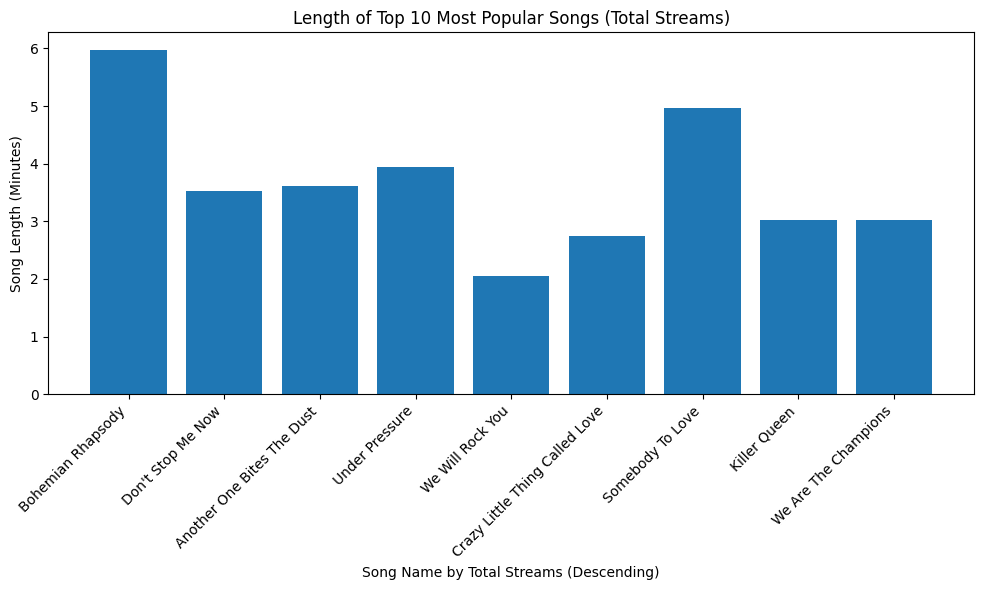

In [42]:
plt.figure(figsize=(10, 6))
plt.bar(hit_calculation['Name'], hit_calculation['Minute'])

plt.xlabel('Song Name by Total Streams (Descending)')
plt.ylabel('Song Length (Minutes)')
plt.title('Length of Top 10 Most Popular Songs (Total Streams)')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

## Percentage of Composers

In [43]:
com_df = track_full.groupby("Composer")["TrackId"].count()
percent = np.array(com_df.values)
mylabels = np.array(com_df.index.values)

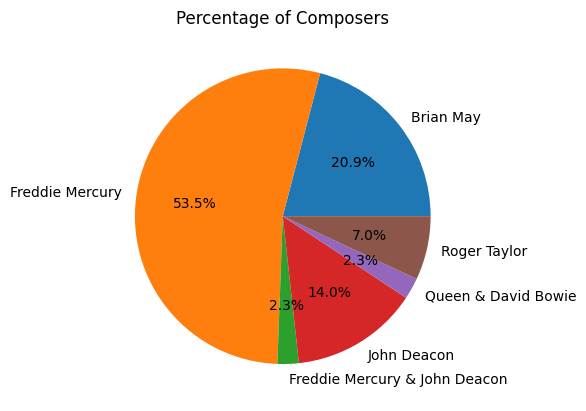

In [44]:
plt.pie(percent, labels = mylabels, autopct="%1.1f%%")
plt.title("Percentage of Composers")
plt.show()